Final-year Project: Spacecraft Docking Simulation

I. Obtain the general solutions of the interceptor's differential equations from the target's frame based on the CW linear model,
then express the motions of the target and interceptor as functions of time from the Earth's static frame.
  

In [2]:
# Import all the packages
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from space_base import GravBody

# Instantiate the constants in SI units
G = 6.67e-11  
earth = GravBody.earth()
M_earth = earth.mass  
R_earth = earth.radius  

# Dimension scaling for easier plotting
dimension_scaling = 1.0e-6

# Time settings
t_final = 3600 * 24
num_points = 1500 
t_vals = np.linspace(0, t_final, num_points) 

# Target spacecraft: circular orbit 
r_target = R_earth + 400_000
omega_target = np.sqrt(G * M_earth / r_target**3)  # Using centripetal force to find the target's angular velocity, typically around 10^-3 rad
inclination_target = np.radians(15.5) # Target's Orbital inclination with respect to the Earth's equatorial plane 

# Generate positions over time intervals for the target 
x_target_earth = r_target * np.cos(omega_target * t_vals)
y_target_earth = r_target * np.sin(omega_target * t_vals) * np.cos(inclination_target)
z_target_earth = r_target * np.sin(omega_target * t_vals) * np.sin(inclination_target)

# Interceptor spacecraft: circular orbit (in CW model)
r_interceptor = r_target + 10
omega_interceptor = np.sqrt(G * M_earth / r_interceptor**3)
inclination_interceptor = np.radians(-50)

# Define a function to solve the CW linear model
def solve_interceptor_motion(thrust_x:float, thrust_y:float):
    """This function solves the CW equation for any given arbitrary constants in thrusts.
    It gives the relative positions of the interceptor from the target's frame S.

    Args:
        thrust_x, thrust_y (float): Thrust values 

    Returns:
        ndarray: x, y and z-positions of the interceptor relative to the target as a function of time

    """
    # Define t as a symbol of time
    t = sp.Symbol('t')

    # Define the integration constants used
    x_01, x_02, y_01, y_02, z_01, z_02, omega_0 = sp.symbols('x_01 x_02 y_01 y_02 z_01 z_02 omega_0', real=True, positive=True)

    # Define x, y, vx, vy & z as functions of time
    x = sp.Function('x')(t)
    y = sp.Function('y')(t)

    vx = sp.Function('vx')(t)
    vy = sp.Function('vy')(t)

    z = sp.Function('z')(t)
    
    # Define the differential equations in x, y & z directions
    eq_vx = sp.Eq(x.diff(t), vx) 
    eq_ax = sp.Eq(vx.diff(t), -2 * omega_0 * vy + thrust_x)

    eq_vy = sp.Eq(y.diff(t), vy) 
    eq_ay = sp.Eq(vy.diff(t), 3 * omega_0**2 * y + 2 * omega_0 * vx + thrust_y)

    eq_z = sp.Eq(z.diff(t, t), -omega_0**2 * z)  

    # Define the initial conditions first, then solve the coupled x-y differential equations
    ics = {x.subs(t, 0): x_01, vx.subs(t, 0): x_02, 
           y.subs(t, 0): y_01, vy.subs(t, 0): y_02,}

    x_y_sol = sp.dsolve([eq_vx, eq_ax, eq_vy, eq_ay], ics=ics)

    # z(t) is not coupled at all, which can be solved independently on its own
    z_sol = sp.dsolve(eq_z, ics={z.subs(t, 0): z_01, z.diff(t).subs(t, 0): z_02})

    # Change the general solutions solved in Sympy format into numeric functions for plotting
    # Initial position of the interceptor: x_01, y_01 & z_01 (m); its initial velocities: x_02, y_02 & z_02 (m/s)
    x_func = sp.lambdify(t, x_y_sol[0].rhs.subs({omega_0: omega_interceptor, x_01: 10, x_02: 0.001, 
                                                y_01: 5, y_02: 0}), 
                                                modules='numpy')

    y_func = sp.lambdify(t, x_y_sol[2].rhs.subs({omega_0: omega_interceptor, x_01: 10, x_02: 0.001, 
                                                y_01: 5, y_02: 0}), 
                                                modules='numpy')

    z_func = sp.lambdify(t, z_sol.rhs.subs({omega_0: omega_interceptor, z_01: 5, z_02: 0}), 
                        modules='numpy')
    
    # Generate relative positions for the interceptor from the general solutions in the target's reference frame 
    x_interceptor_rel = x_func(t_vals) * dimension_scaling
    y_interceptor_rel = y_func(t_vals) * dimension_scaling
    z_interceptor_rel = z_func(t_vals) * dimension_scaling

    return x_interceptor_rel, y_interceptor_rel, z_interceptor_rel

x_interceptor_rel, y_interceptor_rel, z_interceptor_rel = solve_interceptor_motion(0, 0)

# Define a function to transform these relative coordinates into the Earth's static frame
def transform_to_earth_frame(x_interceptor_rel:float, y_interceptor_rel:float, z_interceptor_rel:float):
    """This function convert the relative positions of the interceptor into the Earth's frame S*.
    Args:
        x_interceptor_rel, y_interceptor_rel, z_interceptor_rel: ndarray of the interceptor's relative positions as a function of time 

    Returns:
        ndarray: x, y and z-positions of the interceptor as a function of time in the Earth's frame
    
    """
    x_interceptor_earth = (
        x_target_earth + (
            x_interceptor_rel * np.cos(omega_target * t_vals)
            - y_interceptor_rel * np.sin(omega_target * t_vals)
        )
        )

    y_interceptor_earth = (
        y_target_earth + (
            x_interceptor_rel * np.sin(omega_target * t_vals)
            + y_interceptor_rel * np.cos(omega_target * t_vals)
            ) * np.cos(inclination_interceptor)
            )

    z_interceptor_earth = (
        z_target_earth + (
            z_interceptor_rel * np.sin(inclination_interceptor)
            )
            )
    return x_interceptor_earth, y_interceptor_earth, z_interceptor_earth

x_interceptor_earth, y_interceptor_earth, z_interceptor_earth = transform_to_earth_frame(x_interceptor_rel, 
                                                                                         y_interceptor_rel, z_interceptor_rel)

II. Parametrisation of Orbits

a. Whifferdill Turns with No Thrusts

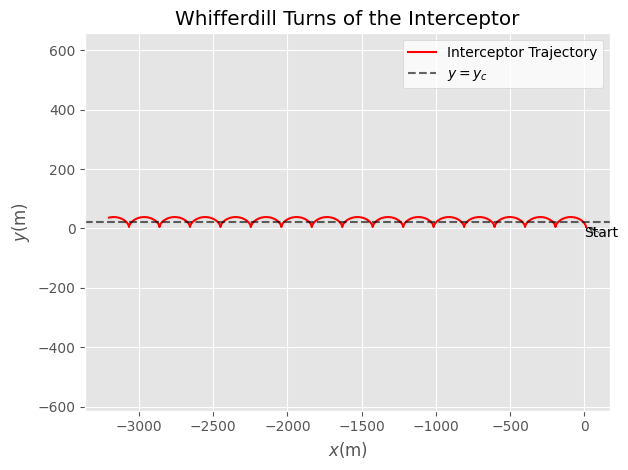

In [3]:
plt.style.use('ggplot')

plt.plot(x_interceptor_rel / dimension_scaling, y_interceptor_rel / dimension_scaling, 'red')

x_02 = 0.001
y_01 = 5
yc = 4 * y_01 + 2 * x_02 / omega_interceptor

plt.axhline(yc, color='black', linestyle='--', alpha=0.6)

plt.xlabel(r'$x$(m)')
plt.ylabel(r'$y$(m)')
plt.title("Whifferdill Turns of the Interceptor")
plt.legend(['Interceptor Trajectory', r'$y = y_c$'], 
            loc='best').get_frame().set_facecolor('white') 

plt.annotate(
    'Start', xy=(10, 5), xytext=(0, -30),
    arrowprops={'arrowstyle': '->', 'color':'black'}
)

plt.gca().set_aspect(2, adjustable='datalim')
plt.tight_layout()
plt.savefig('Fig. 2a.png', dpi=300)
plt.show()

b. Orbits of both spacecraft when viewed from the Earth

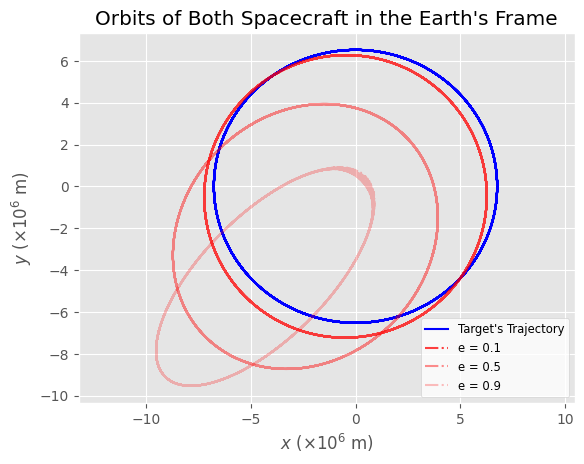

In [ ]:
# Define a function that solves Kepler's equation
def kepler_solver(e:float, a=(R_earth + 400e3), i=0, arg_periapsis=np.radians(45)):
    """This function solve Kepler's equation for any given value of eccentricity.
    We then solve the equation numerically using Newton-Raphson method.
    Finally, it gives the positions of the interceptor in the Earth's frame.

    Args:
        e (float): Eccentricity, 0 < e < 1 for elliptical orbits.
        a (floar): Semi-major Axis. Defaults to '6371e3 + 400e3'
        i (float, optional): Inclination angle. Defaults to '0'
        arg_periapsis = Argument of periapsis. Defaults to 'np.radians(45)'

    Returns:
        ndarray: x, y and z-positions of the interceptor in the Earth's frame

    """
    # Orbital parameters for the interceptor in solving Kepler's equation
    omega_kepler = np.sqrt(G * M_earth / a**3)  # Angular velocity of the interceptor

    # Solve Kepler's equation
    M = omega_kepler * t_vals
    E = M.copy()
    for _ in range(100):  # Iterative numeric solution using Newton-Raphson method
        E = M + e * np.sin(E)

    # True anomaly
    nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), np.sqrt(1 - e) * np.cos(E / 2))

    # Orbital radius
    r_kepler = a * (1 - e**2) / (1 + e * np.cos(nu))

    # Orbital plane coordinates
    x_orbital = r_kepler * np.cos(nu)
    y_orbital = r_kepler * np.sin(nu)
    z_orbital = np.zeros_like(x_orbital)

    # Rotate to inertial frame
    # When looking down from the zenith, the visualisation would be better if we set the inclination to zero
    x_interceptor_earth_kepler = (x_orbital * (np.cos(arg_periapsis)) - y_orbital * (np.sin(arg_periapsis) * np.cos(i)))
    y_interceptor_earth_kepler = (x_orbital * (np.sin(arg_periapsis)) + y_orbital * (np.cos(arg_periapsis) * np.cos(i)))
    z_interceptor_earth_kepler = (y_orbital * np.sin(i))

    return x_interceptor_earth_kepler, y_interceptor_earth_kepler, z_interceptor_earth_kepler

# Plotting
plt.style.use('ggplot')

plt.plot(x_target_earth * dimension_scaling, y_target_earth * dimension_scaling, 'blue', label="Target's Trajectory")

for e in [0.1, 0.5, 0.9]:
    x, y, _ = kepler_solver(e)
    plt.plot(x * dimension_scaling, y * dimension_scaling, 'red', linestyle='-.', alpha= 0.7 + 0.3 * (1 - np.sqrt(7*e)), label=f'e = {e}', linewidth=1.5)

plt.xlabel(r'$x\ (\times {10^6}\ \mathrm{m})$')
plt.ylabel(r'$y\ (\times {10^6}\ \mathrm{m})$')
plt.title("Orbits of Both Spacecraft in the Earth's Frame")
plt.legend(loc='lower right', fontsize='small').get_frame().set_facecolor('white')

plt.axis('Equal')
plt.savefig('Fig. 2b.png', dpi=300, bbox_inches='tight')

plt.show()

c. Offset in the Two Spacecraft

In [ ]:
plt.clf()

plt.plot((x_target_earth - x_interceptor_earth) / dimension_scaling, (y_target_earth - y_interceptor_earth) / dimension_scaling)

plt.xlabel(r'$x$(m)')
plt.ylabel(r'$y$(m)')
plt.title(r"Offset in $x$ & $y$-coordinates as a Function of Time")

plt.annotate(
    'Start', xy=(-10, -5), xytext=(-50, -50),
    arrowprops={'arrowstyle': '->', 'color':'black'}
)

plt.savefig('Fig. 2c.png', dpi=300)
plt.show()

d. Relative Motion with Thrusts in x-Direction

In [ ]:
x_interceptor_rel_no_thrust = x_interceptor_rel.copy()
y_interceptor_rel_no_thrust = y_interceptor_rel.copy()

###########################################################################################################################################################
# UPDATE the differential equations in (+x) directions

x_interceptor_rel_plus_tang, y_interceptor_rel_plus_tang, z_interceptor_rel = solve_interceptor_motion(0.05, 0)

x_interceptor_earth, y_interceptor_earth, z_interceptor_earth = transform_to_earth_frame(x_interceptor_rel_plus_tang, 
                                                                                         y_interceptor_rel_plus_tang, z_interceptor_rel)
plus_x_tang_earth = x_interceptor_earth.copy()
plus_y_tang_earth = y_interceptor_earth.copy()

###########################################################################################################################################################
# UPDATE the differential equations in (-x) directions
x_interceptor_rel_minus_tang, y_interceptor_rel_minus_tang, z_interceptor_rel = solve_interceptor_motion(-0.05, 0)

x_interceptor_earth, y_interceptor_earth, z_interceptor_earth = transform_to_earth_frame(x_interceptor_rel_minus_tang, 
                                                                                         y_interceptor_rel_minus_tang, z_interceptor_rel)
###########################################################################################################################################################
minus_x_tang_earth = x_interceptor_earth.copy()
minus_y_tang_earth = y_interceptor_earth.copy()

plt.plot(x_target_earth, y_target_earth, 'blue', linewidth=2)
plt.plot(plus_x_tang_earth, plus_y_tang_earth, 'purple')
plt.plot(minus_x_tang_earth, minus_y_tang_earth, 'green')

plt.xlabel(r'$x\ (\times {10^6}\ \mathrm{m})$')
plt.ylabel(r'$y\ (\times {10^6}\ \mathrm{m})$')
plt.title(r"Interceptor's Trajectories with Thrusts in ${x}$-Direction")
plt.legend(['Target Trajectory',
            r'Interceptor Trajectory (+${F_x}$)', 
            r'Interceptor Trajectory (-${F_x}$)'],
            loc='best').get_frame().set_facecolor('white') 

plt.annotate(
    'Start', xy=(6.7, 0), xytext=(10, -3),
    arrowprops={'arrowstyle': '->', 'color':'black'}
)

plt.gca().set_aspect(1, adjustable='datalim')
plt.tight_layout()
plt.savefig('Fig. 6.png', dpi=300, bbox_inches='tight')
plt.show()

e. Relative Motion with Thrusts in y-Direction

In [ ]:
###########################################################################################################################################################
# UPDATE the differential equations in (+y) directions
x_interceptor_rel_plus_rad, y_interceptor_rel_plus_rad, z_interceptor_rel = solve_interceptor_motion(0, 0.05)

x_interceptor_earth, y_interceptor_earth, z_interceptor_earth = transform_to_earth_frame(x_interceptor_rel_plus_rad, y_interceptor_rel_plus_rad, z_interceptor_rel)

plus_x_rad_earth = x_interceptor_earth.copy()
plus_y_rad_earth = y_interceptor_earth.copy()
###########################################################################################################################################################
# UPDATE the differential equations in (-y) directions
x_interceptor_rel_minus_rad, y_interceptor_rel_minus_rad, z_interceptor_rel = solve_interceptor_motion(0, -0.05)

x_interceptor_earth, y_interceptor_earth, z_interceptor_earth = transform_to_earth_frame(x_interceptor_rel_minus_rad, y_interceptor_rel_minus_rad, z_interceptor_rel)

minus_x_rad_earth = x_interceptor_earth.copy()
minus_y_rad_earth = y_interceptor_earth.copy()

plt.plot(x_target_earth, y_target_earth, 'blue', linewidth=2)
plt.plot(plus_x_rad_earth, plus_y_rad_earth, 'magenta')
plt.plot(minus_x_rad_earth, minus_y_rad_earth, 'orange')

plt.xlabel(r'$x\ (\times {10^6}\ \mathrm{m})$')
plt.ylabel(r'$y\ (\times {10^6}\ \mathrm{m})$')
plt.title(r"Interceptor's Trajectories with Thrusts in ${y}$-Direction")
plt.legend(['Target Trajectory', 
            r'Interceptor Trajectory (+${F_y}$)', 
            r'Interceptor Trajectory (-${F_y}$)'],
            loc='best').get_frame().set_facecolor('white') 

plt.annotate(
    'Start', xy=(6.7, 0), xytext=(8, -2),
    arrowprops={'arrowstyle': '->', 'color':'black'}
)

plt.gca().set_aspect(1, adjustable='datalim')
plt.tight_layout()
plt.savefig('Fig. 8.png', dpi=300, bbox_inches='tight')
plt.show()

f. Comparison of All Whifferdill Turns

In [ ]:
# Plotting
plt.clf()

plt.plot(x_interceptor_rel_plus_tang, y_interceptor_rel_plus_tang, 'purple')
plt.plot(x_interceptor_rel_minus_tang, y_interceptor_rel_minus_tang, 'green')
plt.plot(x_interceptor_rel_plus_rad, y_interceptor_rel_plus_rad, 'magenta')
plt.plot(x_interceptor_rel_minus_rad, y_interceptor_rel_minus_rad, 'orange')
plt.xlim(-1.5, 1.5)
plt.ylim(-0.5, 0.5)

plt.xlabel(r'$x\ (\times {10^6}\ \mathrm{m})$')
plt.ylabel(r'$y\ (\times {10^6}\ \mathrm{m})$')
plt.title("Comparison of the Interceptor's Whifferdill Turns")
plt.legend([r'+$F_x / m$',  r'-$F_x / m$',
            r'+$F_y / m$',  r'-$F_y / m$'], 
            loc='best').get_frame().set_facecolor('white') 

plt.annotate(
    'Start', xy=(0.005, 0.005), xytext=(0.2, 0.1),
    arrowprops={'arrowstyle': '->', 'color':'black'}
)

plt.gca().set_aspect(1, adjustable='datalim')
plt.tight_layout()
plt.savefig('Fig. 7.png', dpi=300, bbox_inches='tight')
plt.show()

III. Docking Optimisation

a. Lambert's Transfer

In [ ]:
import plotly.graph_objs as go
import plotly

x_interceptor_earth_kepler, y_interceptor_earth_kepler, z_interceptor_earth_kepler = kepler_solver(e=0.5, i=np.radians(15))

# A. Animating the motions of target and interceptor in the Earth's frame
# Plot the Earth's surface in spherical polar coordinates as a transparent sphere
theta, phi = np.mgrid[0: 2 * np.pi: 30j, 0: np.pi: 15j]
trace_earth = go.Surface(
    x = R_earth * np.sin(phi) * np.cos(theta) * dimension_scaling,
    y = R_earth * np.sin(phi) * np.sin(theta) * dimension_scaling,
    z = R_earth * np.cos(phi) * dimension_scaling,
    colorscale='Blues',
    opacity=0.5,
    name='Earth',
    showscale=False,
    hoverinfo='skip'
)

# Instantiate empty traces for both the target and interceptor's trajectories and current positions
empty_trace_target = go.Scatter3d(
    x=[], y=[], z=[],
    mode='lines',
    line=dict(color='navy', width=4),
    name='Target Trajectory'
)

empty_trace_target_current = go.Scatter3d(
    x=[], y=[], z=[],
    mode='markers',
    marker=dict(color='navy', size=4, symbol='circle-open'),
    name='Target Spacecraft'
)

empty_trace_interceptor = go.Scatter3d(
    x=[], y=[], z=[],
    mode='lines',
    line=dict(color='crimson', width=5),
    name='Interceptor Trajectory'
)

empty_trace_interceptor_current = go.Scatter3d(
    x=[], y=[], z=[],
    mode='markers',
    marker=dict(color='crimson', size=5, symbol='diamond-open'),
    name='Interceptor Spacecraft'
)
# Define the frames for animation, update the previous frame over time
frames = []

# Define how many data points should fade in the trajectories' tails
fade_tail_length = 30

time_scaling = 60 # 1 sec in animation = 1 real minute
delta_t = t_final / num_points

for i in range(num_points):
    simulated_time = i 
    hrs = int(simulated_time // 3600)
    mins = int((simulated_time % 3600) // 60)
    secs = int(simulated_time % 60)
    time_elapsed = f"{hrs:02}:{mins:02}:{secs:02}"

    # Target
    trace_target = go.Scatter3d(
        x=x_target_earth[:i+1] * dimension_scaling,
        y=y_target_earth[:i+1] * dimension_scaling,
        z=z_target_earth[:i+1] * dimension_scaling,
        mode='lines',
        line=dict(color='navy', width=4),
        name='Target Trajectory',
        showlegend=True
    )
    # Current target position
    trace_target_current = go.Scatter3d(
        x=[x_target_earth[i] * dimension_scaling] ,
        y=[y_target_earth[i] * dimension_scaling],
        z=[z_target_earth[i] * dimension_scaling],
        mode='markers',
        marker=dict(color='navy', size=4, symbol='circle-open'),
        name='Target Spacecraft',
        showlegend=True
    )
    # Interceptor
    trace_interceptor = go.Scatter3d(
        x=x_interceptor_earth_kepler[:i+1] * dimension_scaling,
        y=y_interceptor_earth_kepler[:i+1] * dimension_scaling,
        z=z_interceptor_earth_kepler[:i+1] * dimension_scaling,
        mode='lines',
        line=dict(color='crimson', width=5),
        name='Interceptor Trajectory',
        showlegend=True
    )
    # Current interceptor position
    trace_interceptor_current = go.Scatter3d(
        x=[x_interceptor_earth_kepler[i] * dimension_scaling],
        y=[y_interceptor_earth_kepler[i] * dimension_scaling],
        z=[z_interceptor_earth_kepler[i] * dimension_scaling],
        mode='markers',
        marker=dict(color='crimson', size=5, symbol='diamond-open'),
        name='Interceptor Spacecraft',
        showlegend=True
    )
    
    frame_data = [trace_earth,
                  trace_target, trace_target_current, 
                  trace_interceptor, trace_interceptor_current]
    
    frame_annot = [
        dict(
            x=0.1, y=0.1, xref='paper', yref='paper',
            text=f"Total Time Elapsed: {time_elapsed}",
            showarrow=False,
            font=dict(size=15, color='black')
        )
    ]

    frames.append(go.Frame(data=frame_data, layout=dict(annotations=frame_annot)))

# Define the Plot setup using Plotly
layout = go.Layout(
    title='Spacecraft Docking Simulation',
    scene=dict(
        xaxis=dict(title='x (x 10^6 m)', range=[-30, 30]),
        yaxis=dict(title='y (x 10^6 m)', range=[-30, 30]),
        zaxis=dict(title='z (x 10^6 m)', range=[-30, 30]),
        camera=dict(
            up=dict(x=0, y=0, z=1),
            eye=dict(x=1.5, y=1.5, z=1.2)
        ),
        aspectmode='cube'
    ),
    updatemenus=[
        dict(
            type='buttons',
            showactive=False,
            buttons=[
                dict(label='Play',
                     method='animate',
                     args=[None, dict(
                        frame=dict(duration=30, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True, 
                        mode='immediate'
                        )]
                    ),
                dict(label='Pause',
                     method='animate',
                     args=[[None], dict(
                         frame=dict(duration=0, redraw=False), 
                         transition=dict(duration=0),
                         mode='immediate', 
                         fromcurrent=True
                         )]
                    ),
                dict(label='Reset',
                     method='animate',
                     args=[[0], dict(
                         frame=dict(duration=0, redraw=False), 
                         transition=dict(duration=0),
                         mode='immediate',
                         fromcurrent=False
                     )]
                )
            ]
        )
    ],
    showlegend=True
)

# Initial data for the figure
init_data = [
    trace_earth,
    empty_trace_target, empty_trace_target_current,
    empty_trace_interceptor, empty_trace_interceptor_current
]

frames.insert(0, go.Frame(data=init_data))

# Create figure with frames for animation
fig = go.Figure(data=init_data, layout=layout, frames=frames)

# Adding persistence to ensure interactive control during animation
fig.update_layout(scene_camera=dict(eye=dict(x=1.5, y=1.5, z=1.2)))

# Plot to a single HTML file
plotly.offline.plot(fig, filename='1_spacecraft_docking_simulation.html', 
                    auto_open=false)

'1_spacecraft_docking_simulation.html'

Initial velocity for transfer: [-3.6047861  -2.37242153 -0.59442785] km / s
Final velocity at docking: [6.26467978 4.02090699 0.78187678] km / s
Required delta-v: 6.9689310142089305 km / s


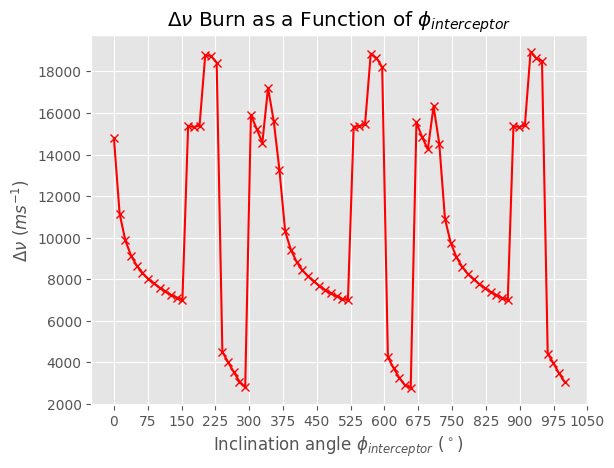

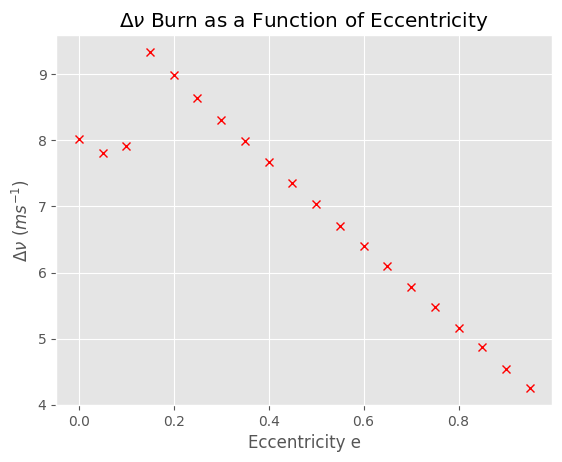

In [44]:
from astropy import units as u
from poliastro.bodies import Earth
from poliastro.iod.izzo import lambert
from matplotlib.ticker import MultipleLocator

def lambert_transfer(xi, yi, zi, xt, yt, zt, tf=3600*u.s):
    """
    Args:

    Returns:

    """
    # Find the optimum time intervel to achieve the shortest transfer
    distance_diff = np.linalg.norm(np.array([xt, yt, zt]) - np.array([xi, yi, zi]), axis=0)

    t_optimum = np.argmin(distance_diff)

    # Define gravitational parameter
    mu = Earth.k

    # Define initial and final positions in ECI frame
    r1 = np.array([xi[t_optimum], yi[t_optimum], zi[t_optimum]]) * u.m 
    r2 = np.array([xt[t_optimum], yt[t_optimum], zt[t_optimum]]) * u.m 

    r1 = r1.to(u.km); r2 = r2.to(u.km)

    # Solve Lambert's problem
    v1, v2 = lambert(mu, r1, r2, tf)

    v_initial = np.array([
        (xi[t_optimum] - xi[t_optimum - 1]) / (t_vals[t_optimum] - t_vals[t_optimum - 1]),
        (yi[t_optimum] - yi[t_optimum - 1]) / (t_vals[t_optimum] - t_vals[t_optimum - 1]),
        (zi[t_optimum] - zi[t_optimum - 1]) / (t_vals[t_optimum] - t_vals[t_optimum - 1])
    ]) * (u.m / u.s)

    # v_dock = ...
    
    v_initial = v_initial.to(u.km / u.s)

    # Compute required delta-v
    delta_v = np.linalg.norm(v1 - v_initial)

    return delta_v, v1, v2

x_interceptor_earth_kepler, y_interceptor_earth_kepler, z_interceptor_earth_kepler = kepler_solver(e=0.5, i=np.radians(160))
delta_v, v1, v2 = lambert_transfer(x_interceptor_earth_kepler, y_interceptor_earth_kepler, z_interceptor_earth_kepler,
                           x_target_earth, y_target_earth, z_target_earth)

print(f"Initial velocity for transfer: {v1}")
print(f"Final velocity at docking: {v2}")
print(f"Required delta-v: {delta_v.to(u.km / u.s)}")

# Plotting delta_v burn against inclination angle
delta_v_list = []
degrees_list = []

for angle in np.linspace(0, np.radians(1000), 80):
    xi, yi, zi = kepler_solver(e=0.5, i=angle)
    degrees = np.degrees(angle)
    delta_v, _, _ = lambert_transfer(xi, yi, zi,
                 x_target_earth, y_target_earth, z_target_earth)
    
    delta_v = delta_v.to_value(u.m / u.s)

    delta_v_list.append(delta_v)
    degrees_list.append(degrees)
    plt.plot(degrees, delta_v, marker='x', color='r')
    
plt.plot(np.array(degrees_list), np.array(delta_v_list), linestyle='-', color='r')
plt.xlabel(r"Inclination angle $\phi_{interceptor} \ (^\circ) $ ")
plt.ylabel(r"$\Delta \nu \ (ms^{-1})$")
plt.title(r"$\Delta \nu$ Burn as a Function of $\phi_{interceptor}$")

plt.gca().xaxis.set_major_locator(MultipleLocator(75))
plt.show()

# Plotting delta_v burn against eccentricity
for e in np.arange(0, 1, 0.05):
    xi, yi, zi = kepler_solver(e=e, i=np.radians(150))
    delta_v, _, _ = lambert_transfer(xi, yi, zi,
                 x_target_earth, y_target_earth, z_target_earth)
    plt.plot(e, delta_v, marker='x', linestyle='--', color='r')
    
plt.xlabel(r"Eccentricity e")
plt.ylabel(r"$\Delta \nu \ (ms^{-1})$")
plt.title(r"$\Delta \nu$ Burn as a Function of Eccentricity")

plt.show()
